# CASA0006: Data Science for Spatial Systems: Assignment

## Introduction

London has introduced a number of measures aimed at stimulating investment in housing and infrastructure. One of the major interventions in this regard is are the Opportunity Areas, which are defined as "key locations with potential for new homes, jobs and infrastructure of all types" (Mayor of London, n.d.). Since XXX, over 30 Opportunity Areas have been established throughout London. 

While these areas are not specifically targeted at property values, similar policies have been established to influence housing prices in XX and XX. 

This paper employs a regression discontinuity design on record-level property market data to investigate whether the London Opportunity Areas have had a distorting impact on property values in London. It looks at properties on either side of the border of the Opportunity Areas in order to establish whether there is a discontinuity in property values at the threshold. 

The research question it seeks to answer is:

*Have the London Opportunity Areas had a material impact on property values in London?*

Two methods are employed in order to do this:

- A linear regression discontinuity model looking at properties inside and outside the boundary of London's Opportunity Areas
- A regression discontinuity model that includes covariates with information about individual properties

## Data

In the United Kingdom, property market data is available through the national Price Paid dataset (CITE). This consists of record-level data for every transaction going back to 1995. While this is valuable, the utility of the data has been limited by the fact that it does not include a common unique identifier for individual properties such as the Unique Property Reference Number (UPRN). This means that georeferencing the data and linking it to other sources of information has not been possible until recently. 

This changed with Energy XX data, which 

There have been several recent advances in uti

Refs for above: 
Mayor of London OA areas
Price PAid
Bin

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sn
import statsmodels.formula.api as smf


In [2]:
folder_path = 'data/harness/london/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    dfs.append(df)

sales_gdf = pd.concat(dfs)

In [3]:
sales_gdf = gpd.GeoDataFrame(sales_gdf, geometry = gpd.points_from_xy(sales_gdf['SignatureHPIDCentroid_x'], sales_gdf['SignatureHPIDCentroid_y']), crs = 'EPSG:27700')

In [4]:
sales_gdf['LogIndexedPricePerSquareMetre'] = np.log(sales_gdf['IndexedPricePerSquareMetre'])

In [5]:
sales_gdf['SquareMetreSourcePropertyType'].unique()

array(['Flat', 'House', 'Maisonette',
       'B1 Offices and Workshop businesses', 'Retail',
       'Offices and Workshop Businesses', nan,
       'A1/A2 Retail and Financial/Professional services',
       'A3/A4/A5 Restaurant and Cafes/Drinking Establishments and Hot Food takeaways',
       'Office', 'Covered Car Park; General Office; General Retail',
       'General Office',
       'Restaurants and Cafes/Drinking Establishments/Takeaways',
       'Retail/Financial and Professional Services',
       'Restaurant/public house', 'C1 Hotels', 'Bungalow',
       'General Office; General Retail', 'Residential spaces',
       'B8 Storage or Distribution',
       'D2 General Assembly and Leisure plus Night Clubs and Theatres',
       'C2 Residential Institutions - Hospitals and Care Homes',
       'B2 to B7 General Industrial and Special Industrial Groups',
       'Warehouse and storage', 'Schools And Seasonal Public Buildings;',
       'D1 Non-residential Institutions - Community/Day Centre'

In [6]:
residential = ['Flat', 'Maisonette', 'House', 'Bungalow', 'Residential spaces']
sales_gdf = sales_gdf[sales_gdf['SquareMetreSourcePropertyType'].isin(residential)]
sales_gdf['SquareMetreSourcePropertyType'].unique()

array(['Flat', 'House', 'Maisonette', 'Bungalow', 'Residential spaces'],
      dtype=object)

In [7]:
oa_gdf = gpd.read_file("data/oa/Opportunity_Areas/Opportunity_Areas.shp")
oa_gdf.head()

,objectid,layerrefer,siterefere,sitename,address,uprn,borough,planning_a,firstadded,lastupdate,...,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,extrainfo3,missing,geometry
0,1,OPA00000001,21,"Bankside, Borough and London Bridge",None,0,Southwark,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://geo.southwark.gov.uk/connect/analyst/m...,document type: Neighbourhood Plan,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:2015,None,"POLYGON ((531314.000 180683.000, 531361.300 18..."
1,2,OPA00000002,11,Elephant and Castle,None,0,Southwark,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.southwark.gov.uk/planning-and-buil...,document type: SPD / OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:2015,None,"POLYGON ((532338.248 177675.881, 532331.932 17..."
2,3,OPA00000003,8,Croydon,None,0,Croydon,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.croydon.gov.uk/sites/default/files...,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20130101,None,"POLYGON ((532022.186 165038.627, 531991.803 16..."
3,4,OPA00000004,12,Euston,None,0,Camden,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.eustonareaplan.info/wp-content/upl...,document type: Area Plan,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20150101,None,"POLYGON ((528631.297 183519.827, 528615.904 18..."
4,5,OPA00000005,37,White City,None,0,Hammersmith and Fulham,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.lbhf.gov.uk/planning/regeneration-...,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20180201,None,"POLYGON ((523154.330 180016.258, 523143.370 18..."


In [8]:
#oa_gdf = oa_gdf[oa_gdf['borough'] == 'Camden']
#oa_gdf.head()

In [9]:
sales_gdf['LandRegistryTransactionDate'] = pd.to_datetime(sales_gdf['LandRegistryTransactionDate'], infer_datetime_format=True)

sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2722824 entries, 0 to 91522
Data columns (total 20 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   InternalHPID                   object        
 1   SignatureHPID                  object        
 2   UPRN                           float64       
 3   Price                          int64         
 4   PricePerSquareMetre            float64       
 5   LandRegistryTransactionDate    datetime64[ns]
 6   SquareMetreSource              object        
 7   IndexedPrice                   float64       
 8   IndexedPricePerSquareMetre     float64       
 9   LandRegistryPropertyType       object        
 10  SquareMetreSourcePropertyType  object        
 11  NewBuildFlag                   object        
 12  Tenure                         object        
 13  CouncilTaxBand                 object        
 14  LocalAuthorityCode             object        
 15  Signature

In [10]:
oa_gdf['extrainfo3'] = oa_gdf['extrainfo3'].str.replace('Adopted date:', '')

In [11]:
oa_gdf['extrainfo3'] = pd.to_datetime(oa_gdf['extrainfo3'], infer_datetime_format=True)
oa_gdf['extrainfo3']

0    2015-01-01
1    2015-01-01
2    2013-01-01
3    2015-01-01
4    2018-02-01
5    2014-01-01
6    2004-01-01
7    2015-01-01
8    2015-09-01
9    2016-11-01
10   2015-01-01
11   2014-07-01
12   2014-07-01
13   2015-12-01
14   2013-07-01
15   2012-06-01
16   2005-12-01
17   2018-02-01
18   2013-07-01
19   2015-09-01
20   2014-07-01
21   2011-01-01
22   2015-09-01
23   2014-07-01
24   2015-11-01
25   2009-12-01
26   2011-01-01
27   2018-03-01
28   2019-10-14
Name: extrainfo3, dtype: datetime64[ns]

In [12]:
boundary = oa_gdf.boundary.unary_union
buffer = boundary.buffer(100)
buffer = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buffer), crs = 'EPSG:27700')

In [13]:
sales_gdf = gpd.sjoin(sales_gdf, buffer, op='intersects')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

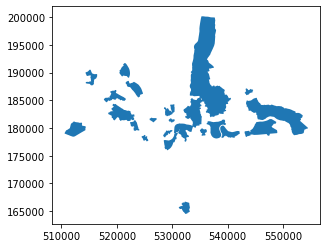

In [14]:
# Create a buffer around the boundary of oa_gdf
oa_gdf_buffer = gpd.GeoDataFrame(geometry=oa_gdf.geometry.buffer(100), crs=oa_gdf.crs)
oa_gdf_buffer = oa_gdf_buffer.merge(oa_gdf[['extrainfo3', 'sitename', 'siterefere']], left_index=True, right_index=True) 
oa_gdf_buffer.plot()

In [15]:
sales_gdf = sales_gdf.drop("index_right", axis = 1)

In [16]:
# Perform a spatial join
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf_buffer, op='intersects')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [17]:
sales_gdf.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry,LogIndexedPricePerSquareMetre,index_right,extrainfo3,sitename,siterefere
1,8ae40ad0-5929-888f-5e4c-ad116c8d830f,5696338a-e97a-1733-8bc1-5b764862987f,2.000001e+11,59995,1071.339286,1997-09-26,Epc Domestic,486827.36,8693.35,F,...,E09000001,533546.9740,181366.2780,NaN,POINT (533546.974 181366.278),9.070314,13,2015-12-01,City Fringe/ Tech City,5
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,...,E09000001,533546.6230,181455.1830,NaN,POINT (533546.623 181455.183),9.287121,13,2015-12-01,City Fringe/ Tech City,5
45,42513910-6f7b-f875-1128-bce84dafe3e7,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,775000,11742.424242,2016-03-24,Epc Domestic,911982.30,13817.91,F,...,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),9.533721,13,2015-12-01,City Fringe/ Tech City,5
48,1d4d4252-6766-db82-f077-b6256ee0d874,05d0e8fe-af68-ed9d-5bd6-63e3d3a86f58,2.000001e+11,70000,1750.000000,1996-12-02,Epc Domestic,614226.68,15355.67,F,...,E09000001,532372.2845,181984.0035,NaN,POINT (532372.285 181984.003),9.639240,13,2015-12-01,City Fringe/ Tech City,5
49,0f757121-e336-46e3-3695-9387b1ed7481,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,505000,14027.777778,2021-06-25,Epc Domestic,610469.43,16957.48,F,...,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),9.738464,13,2015-12-01,City Fringe/ Tech City,5


In [18]:
sales_gdf = sales_gdf.drop("index_right", axis = 1)
sales_gdf.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,CouncilTaxBand,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry,LogIndexedPricePerSquareMetre,extrainfo3,sitename,siterefere
1,8ae40ad0-5929-888f-5e4c-ad116c8d830f,5696338a-e97a-1733-8bc1-5b764862987f,2.000001e+11,59995,1071.339286,1997-09-26,Epc Domestic,486827.36,8693.35,F,...,NaN,E09000001,533546.9740,181366.2780,NaN,POINT (533546.974 181366.278),9.070314,2015-12-01,City Fringe/ Tech City,5
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,...,NaN,E09000001,533546.6230,181455.1830,NaN,POINT (533546.623 181455.183),9.287121,2015-12-01,City Fringe/ Tech City,5
45,42513910-6f7b-f875-1128-bce84dafe3e7,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,775000,11742.424242,2016-03-24,Epc Domestic,911982.30,13817.91,F,...,E,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),9.533721,2015-12-01,City Fringe/ Tech City,5
48,1d4d4252-6766-db82-f077-b6256ee0d874,05d0e8fe-af68-ed9d-5bd6-63e3d3a86f58,2.000001e+11,70000,1750.000000,1996-12-02,Epc Domestic,614226.68,15355.67,F,...,D,E09000001,532372.2845,181984.0035,NaN,POINT (532372.285 181984.003),9.639240,2015-12-01,City Fringe/ Tech City,5
49,0f757121-e336-46e3-3695-9387b1ed7481,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,505000,14027.777778,2021-06-25,Epc Domestic,610469.43,16957.48,F,...,D,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),9.738464,2015-12-01,City Fringe/ Tech City,5


In [19]:
#result['dateoftransfer'] = pd.to_datetime(result['dateoftransfer'], infer_datetime_format=True)
sales_gdf = sales_gdf[sales_gdf['LandRegistryTransactionDate'] > sales_gdf['extrainfo3']]
sales_gdf.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,CouncilTaxBand,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry,LogIndexedPricePerSquareMetre,extrainfo3,sitename,siterefere
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,...,NaN,E09000001,533546.6230,181455.183,NaN,POINT (533546.623 181455.183),9.287121,2015-12-01,City Fringe/ Tech City,5
45,42513910-6f7b-f875-1128-bce84dafe3e7,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,775000,11742.424242,2016-03-24,Epc Domestic,911982.30,13817.91,F,...,E,E09000001,532358.6555,181951.506,NaN,POINT (532358.655 181951.506),9.533721,2015-12-01,City Fringe/ Tech City,5
49,0f757121-e336-46e3-3695-9387b1ed7481,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,505000,14027.777778,2021-06-25,Epc Domestic,610469.43,16957.48,F,...,D,E09000001,532358.6555,181951.506,NaN,POINT (532358.655 181951.506),9.738464,2015-12-01,City Fringe/ Tech City,5
125,6e24c9d3-c563-dc9c-34db-ed59502d8a42,259f167a-2fee-5abc-2afe-503619b03c05,1.000200e+11,725000,9177.215190,2019-08-13,Epc Domestic,834184.82,10559.30,F,...,NaN,E09000001,533777.7795,180985.317,NaN,POINT (533777.779 180985.317),9.264762,2015-12-01,City Fringe/ Tech City,5
343,b41a7ae7-70b3-bb7c-1c37-afb994af87ae,98ccae49-321d-f44d-f351-a54b92ac1779,9.551513e+07,980000,8305.084746,2020-09-07,Epc Domestic,1145219.21,9705.25,O,...,G,E09000001,533708.8720,181227.084,NaN,POINT (533708.872 181227.084),9.180422,2015-12-01,City Fringe/ Tech City,5


In [20]:
points_within = gpd.sjoin(sales_gdf, oa_gdf.drop(["extrainfo3", "siterefere", "sitename"], axis = 1), op="within") #drop extrainfo3 as it is already in sales_gdf
points_within.info()

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 31144 entries, 1500 to 91501
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   InternalHPID                   31144 non-null  object        
 1   SignatureHPID                  31144 non-null  object        
 2   UPRN                           30440 non-null  float64       
 3   Price                          31144 non-null  int64         
 4   PricePerSquareMetre            31144 non-null  float64       
 5   LandRegistryTransactionDate    31144 non-null  datetime64[ns]
 6   SquareMetreSource              31144 non-null  object        
 7   IndexedPrice                   31143 non-null  float64       
 8   IndexedPricePerSquareMetre     31143 non-null  float64       
 9   LandRegistryPropertyType       31144 non-null  object        
 10  SquareMetreSourcePropertyType  31144 non-null  object        
 11  NewB

In [21]:
points_outside = sales_gdf[~sales_gdf.index.isin(points_within.index)]
points_outside.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14295 entries, 3 to 91094
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   InternalHPID                   14295 non-null  object        
 1   SignatureHPID                  14295 non-null  object        
 2   UPRN                           14004 non-null  float64       
 3   Price                          14295 non-null  int64         
 4   PricePerSquareMetre            14295 non-null  float64       
 5   LandRegistryTransactionDate    14295 non-null  datetime64[ns]
 6   SquareMetreSource              14295 non-null  object        
 7   IndexedPrice                   14295 non-null  float64       
 8   IndexedPricePerSquareMetre     14295 non-null  float64       
 9   LandRegistryPropertyType       14295 non-null  object        
 10  SquareMetreSourcePropertyType  14295 non-null  object        
 11  NewBuil

In [22]:
points_outside['InternalHPID'].nunique()

12661

In [23]:
# Calculate distance from each point to boundary
boundary = oa_gdf.boundary.unary_union
points_within["distance"] = points_within.geometry.apply(lambda x: x.distance(boundary))
points_outside["distance"] = -points_outside.geometry.apply(lambda x: x.distance(boundary))

# Concatenate subsets back together
result = gpd.GeoDataFrame(pd.concat([points_within, points_outside], ignore_index=True))

result.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,northing,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,missing,distance
0,49affb6d-74e1-a433-b9e3-7b17534a96dd,2d74fba1-b181-ee07-f5cf-7a45544d6408,6.196258e+06,500000,8620.689655,2018-11-16,Epc Domestic,611640.22,10545.52,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,49.452535
1,b9685e2b-568d-3b84-96ea-90950f496728,30fad42f-c6e8-60e5-0b7c-60ff8617388a,1.000834e+10,599995,7142.797619,2016-12-16,Epc Domestic,699698.09,8329.74,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,26.148730
2,b1873ed3-a1af-b3da-2f22-681a854d3f46,6cc65415-bf50-8143-e563-4bebec64a435,1.000210e+11,159000,10600.000000,2017-04-07,Epc Domestic,197500.69,13166.71,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,31.405855
3,48f25f4c-b3ac-4ae8-7140-717757dbe6af,1400d413-ff8d-02d7-55e1-01aadf0a980c,NaN,158750,1935.975610,2016-10-25,Epc Domestic,186227.36,2271.07,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,48.666124
4,0e99b7e5-1c4e-ab9f-06d1-9831f3c6d65c,4b81c8a0-8aef-3940-adcb-2ace23db9f84,1.000834e+10,790000,10675.675676,2016-08-19,Epc Domestic,964417.56,13032.67,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,35.050612


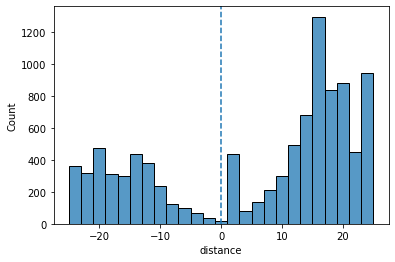

In [35]:
sn.histplot(result[(result['distance'] < 25) & (result['distance'] > -25)], x = 'distance', bins = 25)
plt.axvline(x=0, linestyle="--")
plt.show()

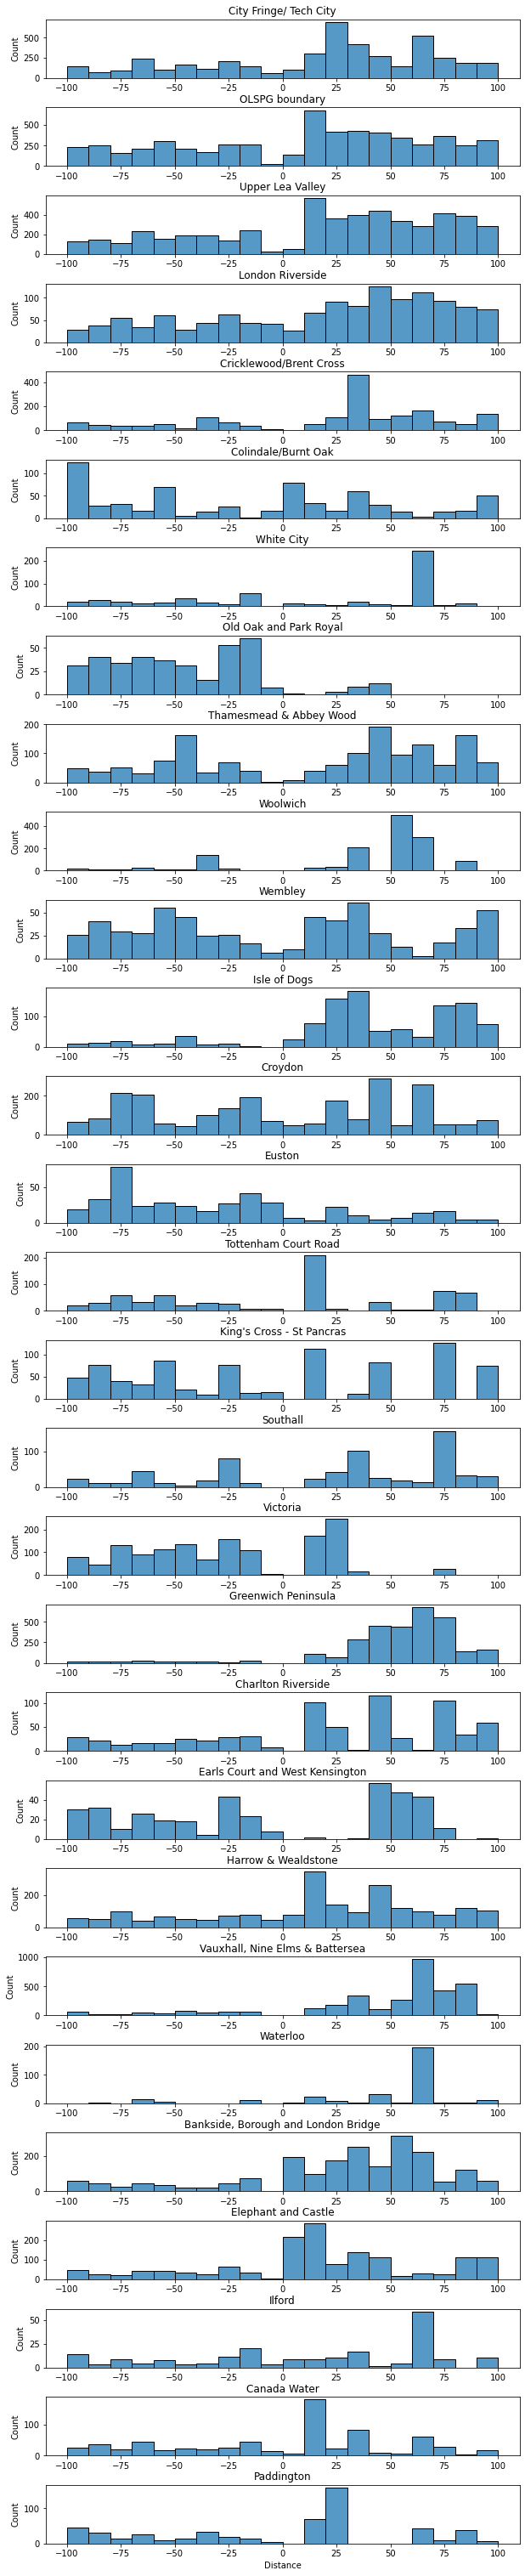

In [61]:
fig, axes = plt.subplots(nrows=len(result['sitename'].unique()), ncols=1, figsize=(10,50))

for i, sitename in enumerate(result['sitename'].unique()):
    sn.histplot(data=result[result['sitename'] == sitename], x='distance', ax=axes[i], bins = 20, binrange =(-100, 100))
    axes[i].set_title(sitename)
    fig.subplots_adjust(hspace=0.5, top = 0.95)

    if i == len(result['sitename'].unique()) - 1:
        axes[i].set_xlabel('Distance')
    else:
        axes[i].set_xlabel('')
plt.show()

<AxesSubplot:xlabel='distance', ylabel='Count'>

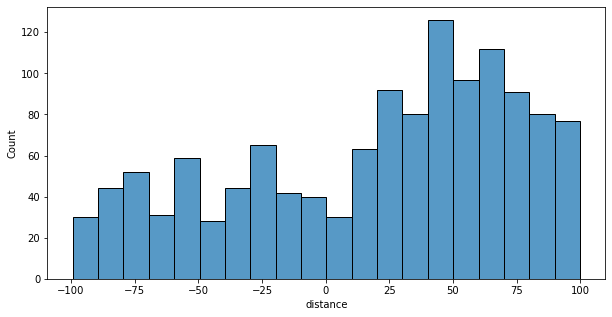

In [75]:
plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)
sn.histplot(result[result['sitename'] == 'London Riverside'], x = 'distance', bins = 20)

<AxesSubplot:xlabel='distance', ylabel='Count'>

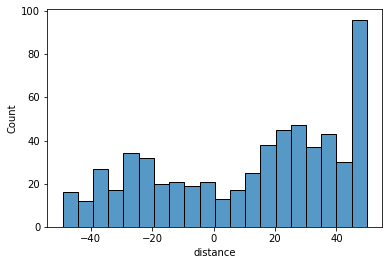

In [47]:
sn.histplot(result[(result['sitename'] == 'London Riverside') &(result['distance'] < 50) & (result['distance'] > -50)], x = 'distance', bins = 20)

In [29]:
result['sitename'].unique()

array(['City Fringe/ Tech City', 'OLSPG boundary', 'Upper Lea Valley',
       'London Riverside', 'Cricklewood/Brent Cross',
       'Colindale/Burnt Oak', 'White City', 'Old Oak and Park Royal',
       'Thamesmead & Abbey Wood', 'Woolwich', 'Wembley', 'Isle of Dogs',
       'Croydon', 'Euston', 'Tottenham Court Road',
       "King's Cross - St Pancras", 'Southall', 'Victoria',
       'Greenwich Peninsula', 'Charlton Riverside',
       'Earls Court and West Kensington', 'Harrow & Wealdstone',
       'Vauxhall, Nine Elms & Battersea', 'Waterloo',
       'Bankside, Borough and London Bridge', 'Elephant and Castle',
       'Ilford', 'Canada Water', 'Paddington'], dtype=object)

<AxesSubplot:>

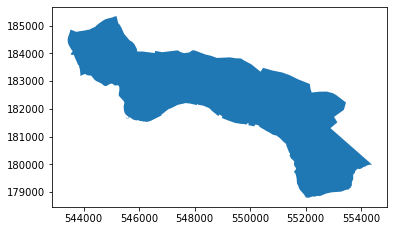

In [32]:
oa_gdf[oa_gdf['sitename'] == 'London Riverside'].plot()

<AxesSubplot:>

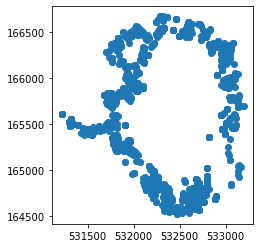

In [69]:
result[result['sitename'] == 'Croydon'].plot()

Text(0.5, 1.0, 'Price per square metre by distance from OA boundary')

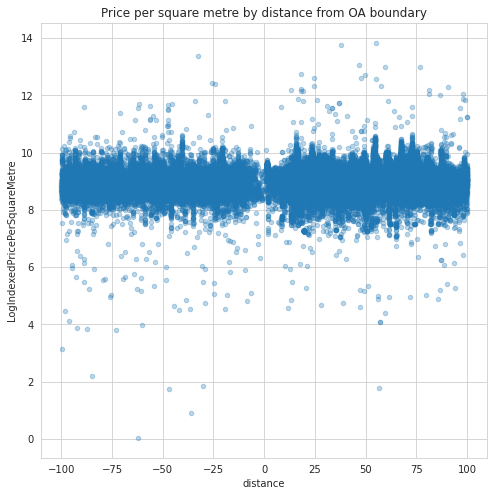

In [119]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
result[(result['distance'] < 100) & (result['distance'] > -100)].plot.scatter(x="distance", y="LogIndexedPricePerSquareMetre", ax=ax, alpha = 0.3)
plt.title("Price per square metre by distance from OA boundary")


In [136]:
rdd_df = result.assign(threshold=(result["distance"] > 0).astype(int))
model = smf.wls("LogIndexedPricePerSquareMetre ~ distance * threshold", rdd_df).fit()
print(model.summary())

                                  WLS Regression Results                                 
Dep. Variable:     LogIndexedPricePerSquareMetre   R-squared:                       0.366
Model:                                       WLS   Adj. R-squared:                  0.365
Method:                            Least Squares   F-statistic:                     844.5
Date:                           Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                                   15:36:22   Log-Likelihood:                -24299.
No. Observations:                          45438   AIC:                         4.866e+04
Df Residuals:                              45406   BIC:                         4.894e+04
Df Model:                                     31                                         
Covariance Type:                       nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025 

In [51]:
result_plot = result[['LogIndexedPricePerSquareMetre', 'distance', 'SquareMetreSourcePropertyType', 'NewBuildFlag', 'Tenure', 'CouncilTaxBand']]

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,northing,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,missing,distance
0,49affb6d-74e1-a433-b9e3-7b17534a96dd,2d74fba1-b181-ee07-f5cf-7a45544d6408,6.196258e+06,500000,8620.689655,2018-11-16,Epc Domestic,611640.22,10545.52,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,49.452535
1,b9685e2b-568d-3b84-96ea-90950f496728,30fad42f-c6e8-60e5-0b7c-60ff8617388a,1.000834e+10,599995,7142.797619,2016-12-16,Epc Domestic,699698.09,8329.74,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,26.148730
2,b1873ed3-a1af-b3da-2f22-681a854d3f46,6cc65415-bf50-8143-e563-4bebec64a435,1.000210e+11,159000,10600.000000,2017-04-07,Epc Domestic,197500.69,13166.71,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,31.405855
3,48f25f4c-b3ac-4ae8-7140-717757dbe6af,1400d413-ff8d-02d7-55e1-01aadf0a980c,NaN,158750,1935.975610,2016-10-25,Epc Domestic,186227.36,2271.07,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,48.666124
4,0e99b7e5-1c4e-ab9f-06d1-9831f3c6d65c,4b81c8a0-8aef-3940-adcb-2ace23db9f84,1.000834e+10,790000,10675.675676,2016-08-19,Epc Domestic,964417.56,13032.67,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,35.050612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23265,4494c77f-7df9-ef62-1dd6-ed18c103b182,8af40958-4bb4-a23b-9595-950c9a713303,1.000228e+11,555000,11562.500000,2019-12-20,Epc Domestic,526944.94,10978.02,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.620885
23266,49a11586-4b65-a560-f0e4-79fb398543e4,df3f95d2-958e-3583-969e-9c89e36f87d9,1.000228e+11,560000,9180.327869,2021-05-07,Epc Domestic,583073.25,9558.58,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.465724
23267,f316e08e-ef4d-a6e9-b492-038aaecbe69c,3f363fcf-7161-d857-2bbc-5a82be51594f,1.000228e+11,800000,11428.571429,2022-08-22,Epc Domestic,761747.78,10882.11,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-37.726274
23268,e7c1d189-ab63-ae01-7f65-56cad6d2459f,93f47402-3f60-4da4-f9da-0118944f8af4,1.000228e+11,690000,11311.475410,2017-11-07,Epc Domestic,609480.07,9991.48,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-45.122490


In [145]:
result_rdd = result[['LogIndexedPricePerSquareMetre', 'distance', 'SquareMetreSourcePropertyType', 'NewBuildFlag', 'Tenure', 'CouncilTaxBand']]


In [146]:
result_rdd = pd.get_dummies(data = result_rdd, columns = ['SquareMetreSourcePropertyType', 'NewBuildFlag', 'Tenure', 'CouncilTaxBand',], drop_first = True, dummy_na = True)
result_rdd.head()

,LogIndexedPricePerSquareMetre,distance,SquareMetreSourcePropertyType_Flat,SquareMetreSourcePropertyType_House,SquareMetreSourcePropertyType_Maisonette,SquareMetreSourcePropertyType_Residential spaces,SquareMetreSourcePropertyType_nan,NewBuildFlag_Y,NewBuildFlag_nan,Tenure_L,Tenure_nan,CouncilTaxBand_B,CouncilTaxBand_C,CouncilTaxBand_D,CouncilTaxBand_E,CouncilTaxBand_F,CouncilTaxBand_G,CouncilTaxBand_H,CouncilTaxBand_nan
0,9.263456,49.452535,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,9.027588,26.148730,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,9.485447,31.405855,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,7.728006,48.666124,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,9.475215,35.050612,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [147]:
result_rdd = result_rdd.rename(columns = {"SquareMetreSourcePropertyType_Residential spaces":"SquareMetreSourcePropertyType_Residential_spaces"})

In [148]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [149]:
result_rdd_new = drop_column_using_vif_(result_rdd.drop(['LogIndexedPricePerSquareMetre'], axis=1))

/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping: SquareMetreSourcePropertyType_Flat


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping: CouncilTaxBand_nan


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping: Tenure_L


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [150]:
result_rdd_new.columns

Index(['distance', 'SquareMetreSourcePropertyType_House',
       'SquareMetreSourcePropertyType_Maisonette',
       'SquareMetreSourcePropertyType_Residential_spaces',
       'SquareMetreSourcePropertyType_nan', 'NewBuildFlag_Y',
       'NewBuildFlag_nan', 'Tenure_nan', 'CouncilTaxBand_B',
       'CouncilTaxBand_C', 'CouncilTaxBand_D', 'CouncilTaxBand_E',
       'CouncilTaxBand_F', 'CouncilTaxBand_G', 'CouncilTaxBand_H'],
      dtype='object')

In [151]:
result_rdd = result_rdd[['LogIndexedPricePerSquareMetre', 'distance', 'SquareMetreSourcePropertyType_House',
       'SquareMetreSourcePropertyType_Maisonette',
       'SquareMetreSourcePropertyType_Residential_spaces',
       'SquareMetreSourcePropertyType_nan', 'NewBuildFlag_Y',
       'NewBuildFlag_nan', 'Tenure_nan', 'CouncilTaxBand_B',
       'CouncilTaxBand_C', 'CouncilTaxBand_D', 'CouncilTaxBand_E',
       'CouncilTaxBand_F', 'CouncilTaxBand_G', 'CouncilTaxBand_H']]

In [152]:
rdd_df = result_rdd.assign(threshold=(result["distance"] > 0).astype(int))
model = smf.wls("LogIndexedPricePerSquareMetre ~ distance * threshold + SquareMetreSourcePropertyType_Maisonette + SquareMetreSourcePropertyType_Residential_spaces + SquareMetreSourcePropertyType_nan + NewBuildFlag_nan + Tenure_nan + CouncilTaxBand_B + CouncilTaxBand_C + CouncilTaxBand_D + CouncilTaxBand_E + CouncilTaxBand_F + CouncilTaxBand_G + CouncilTaxBand_H", rdd_df).fit()
print(model.summary())

                                  WLS Regression Results                                 
Dep. Variable:     LogIndexedPricePerSquareMetre   R-squared:                       0.211
Model:                                       WLS   Adj. R-squared:                  0.211
Method:                            Least Squares   F-statistic:                     1015.
Date:                           Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                                   15:59:59   Log-Likelihood:                -29247.
No. Observations:                          45438   AIC:                         5.852e+04
Df Residuals:                              45425   BIC:                         5.863e+04
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                                                       coef    std err          t      P>|t|      [0

In [154]:
# Import the pandas and scipy packages
from scipy.stats import ttest_ind

# Define the treatment and outcome variables
treat = "threshold"
outcome = "LogIndexedPricePerSquareMetre"

# Define the covariates to be checked
covs = ['SquareMetreSourcePropertyType_House',
       'SquareMetreSourcePropertyType_Maisonette',
       'SquareMetreSourcePropertyType_Residential_spaces',
       'SquareMetreSourcePropertyType_nan', 'NewBuildFlag_Y',
       'NewBuildFlag_nan', 'Tenure_nan', 'CouncilTaxBand_B',
       'CouncilTaxBand_C', 'CouncilTaxBand_D', 'CouncilTaxBand_E',
       'CouncilTaxBand_F', 'CouncilTaxBand_G', 'CouncilTaxBand_H']
    
# Create an empty list to store the balance statistics
balance_stats = []

# Loop over the covariates
for cov in covs:
  # Subset the data by treatment and control groups
  treat_df = rdd_df[rdd_df[treat] == 1]
  control_df = rdd_df[rdd_df[treat] == 0]

  # Calculate the mean and standard deviation of the covariate for each group
  treat_mean = treat_df[cov].mean()
  treat_sd = treat_df[cov].std()
  control_mean = control_df[cov].mean()
  control_sd = control_df[cov].std()

  # Calculate the difference and standardized difference between the groups
  diff = treat_mean - control_mean
  std_diff = diff / ((treat_sd + control_sd) / 2)

  # Perform a t-test to compare the means of the groups
  ttest = ttest_ind(treat_df[cov], control_df[cov], equal_var = False)

  # Get the p-value of the t-test
  pval = ttest.pvalue

  # Append the balance statistics to the list as a dictionary
  balance_stats.append({"Covariate": cov, 
                        "Treated Mean": treat_mean, 
                        "Treated SD": treat_sd, 
                        "Control Mean": control_mean, 
                        "Control SD": control_sd, 
                        "Difference": diff, 
                        "Standardized Difference": std_diff, 
                        "p-value": pval})

# Convert the list of dictionaries to a pandas data frame
balance_table = pd.DataFrame(balance_stats)

# Print the balance table
balance_table

/tmp/ipykernel_9017/4143569261.py:34: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = diff / ((treat_sd + control_sd) / 2)
/tmp/ipykernel_9017/4143569261.py:34: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = diff / ((treat_sd + control_sd) / 2)
/tmp/ipykernel_9017/4143569261.py:34: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = diff / ((treat_sd + control_sd) / 2)


,Covariate,Treated Mean,Treated SD,Control Mean,Control SD,Difference,Standardized Difference,p-value
0,SquareMetreSourcePropertyType_House,0.146417,0.353529,0.321301,0.466992,-0.174885,-0.426276,0.000000e+00
1,SquareMetreSourcePropertyType_Maisonette,0.034132,0.181571,0.065058,0.246636,-0.030926,-0.144444,7.110747e-41
2,SquareMetreSourcePropertyType_Residential_spaces,0.000128,0.011332,0.000140,0.011828,-0.000011,-0.000991,9.225042e-01
3,SquareMetreSourcePropertyType_nan,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,NewBuildFlag_Y,0.460891,0.498476,0.151242,0.358297,0.309650,0.722828,0.000000e+00
5,NewBuildFlag_nan,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
6,Tenure_nan,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
7,CouncilTaxBand_B,0.042384,0.201466,0.067296,0.250543,-0.024912,-0.110230,1.859082e-25
8,CouncilTaxBand_C,0.155696,0.362573,0.201119,0.400851,-0.045423,-0.118999,8.622944e-31
9,CouncilTaxBand_D,0.158875,0.365565,0.141238,0.348279,0.017637,0.049413,8.093736e-07


In [155]:
rdd_df = result_rdd.assign(threshold=(result["distance"] > 0).astype(int))
model = smf.wls("LogIndexedPricePerSquareMetre ~ distance * threshold + SquareMetreSourcePropertyType_Maisonette + SquareMetreSourcePropertyType_Residential_spaces + SquareMetreSourcePropertyType_nan + NewBuildFlag_nan + Tenure_nan + CouncilTaxBand_B + CouncilTaxBand_C + CouncilTaxBand_D + CouncilTaxBand_E + CouncilTaxBand_F + CouncilTaxBand_G + CouncilTaxBand_H", rdd_df).fit()
print(model.summary())

                                  WLS Regression Results                                 
Dep. Variable:     LogIndexedPricePerSquareMetre   R-squared:                       0.211
Model:                                       WLS   Adj. R-squared:                  0.211
Method:                            Least Squares   F-statistic:                     1015.
Date:                           Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                                   16:04:08   Log-Likelihood:                -29247.
No. Observations:                          45438   AIC:                         5.852e+04
Df Residuals:                              45425   BIC:                         5.863e+04
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                                                       coef    std err          t      P>|t|      [0

In [34]:
thresh = np.exp(model.params["threshold"] - 1)* 100
intrcpt = np.exp(model.params["Intercept"] - 1) * 100
ate_pct = ((thresh + intrcpt)/intrcpt) * 100
ate_pct

100.0158687475204

In [35]:
intrcpt

240172.4225025619

In [36]:
ate_pct = (np.exp((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"]) - 1)

print("Opportunity areas increase property values by {}%".format(np.round(ate_pct,2)))

Opportunity areas increase property values by 1.73%


/opt/conda/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


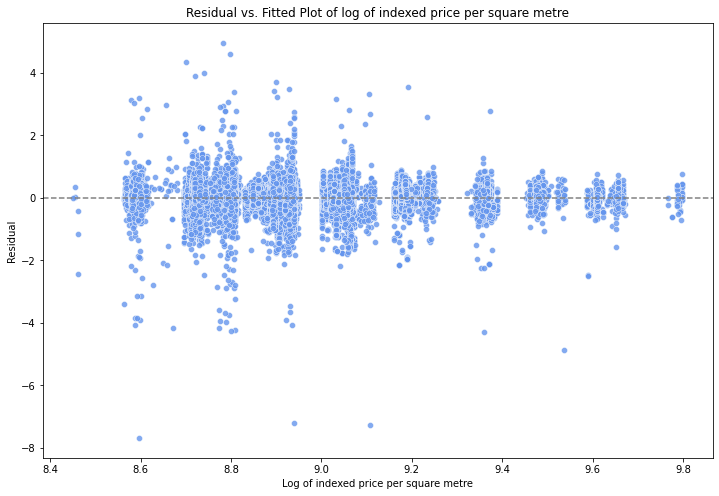

In [37]:
# plot 
fig, ax = plt.subplots(1, figsize=(12,8))
plot = sn.scatterplot(model.fittedvalues, model.resid, alpha = 0.8, color = "cornflowerblue")
plot.axhline(0, color = "grey", linestyle = "--")
# adding title and labels
plt.xlabel('Log of indexed price per square metre')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of log of indexed price per square metre')
plt.savefig('residfits.png', dpi = 200, facecolor = "white")
plt.show()

<AxesSubplot:ylabel='Count'>

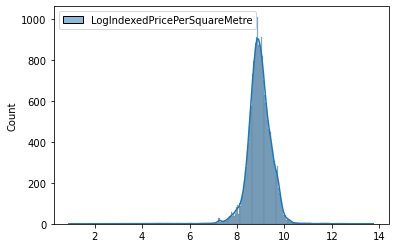

In [38]:
sn.histplot(data = result_rdd[['LogIndexedPricePerSquareMetre']], kde = True)

In [156]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

In [168]:
kernel(result_rdd["distance"], c=0, h=100)

0        0.505475
1        0.738513
2        0.685941
3        0.513339
4        0.649494
           ...   
45434    0.548775
45435    0.004118
45436    0.702571
45437    0.214006
45438    0.041274
Name: distance, Length: 45439, dtype: float64

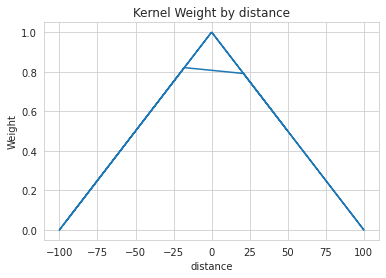

In [167]:
plt.plot(result_rdd["distance"], kernel(result_rdd["distance"], c=0, h=100))
plt.xlabel("distance")
plt.ylabel("Weight")
plt.title("Kernel Weight by distance");

In [160]:
model = smf.wls("LogIndexedPricePerSquareMetre ~ distance * threshold + SquareMetreSourcePropertyType_Maisonette + SquareMetreSourcePropertyType_Residential_spaces + SquareMetreSourcePropertyType_nan + NewBuildFlag_nan + Tenure_nan + CouncilTaxBand_B + CouncilTaxBand_C + CouncilTaxBand_D + CouncilTaxBand_E + CouncilTaxBand_F + CouncilTaxBand_G + CouncilTaxBand_H", rdd_df, weights=kernel(result_rdd["distance"], c=0, h=100)).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  WLS Regression Results                                 
=========================================================================================
Dep. Variable:     LogIndexedPricePerSquareMetre   R-squared:                       0.197
Model:                                       WLS   Adj. R-squared:                  0.197
Method:                            Least Squares   F-statistic:                     930.8
Date:                           Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                                   16:06:42   Log-Likelihood:                -35273.
No. Observations:                          45438   AIC:                         7.057e+04
Df Residuals:                              45425   BIC:                         7.069e+04
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            8.8744      0.008   1082.859      0.000       8.858       8.890
distance                                            -0.0004      0.000     -2.189      0.029      -0.001   -4.13e-05
threshold                                            0.0645      0.009      6.886      0.000       0.046       0.083
distance:threshold                                   0.0006      0.000      2.670      0.008       0.000       0.001
SquareMetreSourcePropertyType_Maisonette            -0.1584      0.011    -14.532      0.000      -0.180      -0.137
SquareMetreSourcePropertyType_Residential_spaces    -0.4023      0.171     -2.358      0.018      -0.737      -0.068
SquareMetreSourcePropertyType_nan                -7.386e-17      7e-17     -1.055      0.291   -2.11e-16    6.33e-17
NewBuildFlag_nan                                 -5.173e-16   9.18e-17     -5.637      0.000   -6.97e-16   -3.37e-16
Tenure_nan                                        6.138e-18   6.75e-17      0.091      0.928   -1.26e-16    1.38e-16
CouncilTaxBand_B                                    -0.1733      0.011    -16.165      0.000      -0.194      -0.152
CouncilTaxBand_C                                    -0.2062      0.006    -32.143      0.000      -0.219      -0.194
CouncilTaxBand_D                                     0.0126      0.007      1.874      0.061      -0.001       0.026
CouncilTaxBand_E                                     0.2062      0.007     29.559      0.000       0.192       0.220
CouncilTaxBand_F                                     0.4009      0.009     46.025      0.000       0.384       0.418
CouncilTaxBand_G                                     0.6348      0.011     55.639      0.000       0.612       0.657
CouncilTaxBand_H                                     0.8354      0.019     43.336      0.000       0.798       0.873
==============================================================================
Omnibus:                    21195.786   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1208165.108
Skew:                          -1.460   Prob(JB):                         0.00
Kurtosis:                      28.092   Cond. No.                     1.87e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [64]:
print(model.summary())

                                  WLS Regression Results                                 
Dep. Variable:     LogIndexedPricePerSquareMetre   R-squared:                       0.187
Model:                                       WLS   Adj. R-squared:                  0.187
Method:                            Least Squares   F-statistic:                     445.9
Date:                           Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                                   07:37:06   Log-Likelihood:                   -inf
No. Observations:                          23269   AIC:                               inf
Df Residuals:                              23256   BIC:                               inf
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                                                       coef    std err          t      P>|t|      [0

TypeError: Axes.scatter() got multiple values for argument 'x'

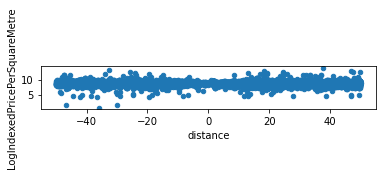

In [43]:
ax = result.plot.scatter(x="distance", y="LogIndexedPricePerSquareMetre", color="C0")
result.assign(predictions=model.fittedvalues).plot(x="distance", y="predictions", ax=ax, color="C1")
plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}% \n p={np.round(model.pvalues['threshold'], 3)}, R2={np.round(model.rsquared, 3)}")
plt.show()